In [1]:
import numpy as np
import numpy as np
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [2]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [3]:
print(os.listdir("/content/drive/MyDrive/ISIC_Labelled"))

['Melanocytic nevus', 'Melanoma', 'Actinic keratosis', 'Vascular lesion', 'Basal cell carcinoma', 'Squamous cell carcinoma', 'Benign keratosis', 'Dermatofibroma']


In [4]:
base_dir = '/content/drive/MyDrive/ISIC_Labelled'

(450, 600, 3)


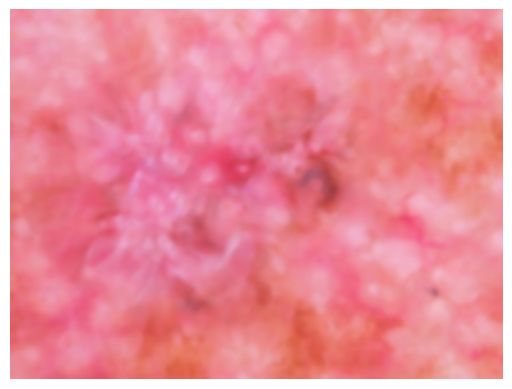

In [5]:
base_dir = '/content/drive/MyDrive/ISIC_Labelled'


image_path = '/content/drive/MyDrive/ISIC_Labelled/Actinic keratosis/ISIC_0024468.jpg'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [6]:
import os

# Define the base directory
 # Change this to your base directory path

# Walk through all files and subdirectories within base_dir
non_image_files = []  # List to store non-image files

for root, dirs, files in os.walk(base_dir):
    for filename in files:
        if not (filename.lower().endswith('.jpeg') or filename.lower().endswith('.jpg')):
            non_image_files.append(os.path.join(root, filename))  # Add the non-image file path to the list

# Print non-image files (if any)
if non_image_files:
    print("Non-image files remaining:")
    for file in non_image_files:
        print(file)
else:
    print("No non-image files found.")


No non-image files found.


In [7]:
import os

# Define the base directory (the parent folder containing subfolders)
 # Change this to your base directory path

# Walk through all files and subdirectories within base_dir
for root, dirs, files in os.walk(base_dir):
    for filename in files:
        file_path = os.path.join(root, filename)

        # Check if the file is not a .jpg or .jpeg file
        if not (filename.lower().endswith('.jpeg') or filename.lower().endswith('.jpg')):
            try:
                print(f"Removing non-image file: {file_path}")  # Debug: Print file being removed
                os.remove(file_path)  # Delete the file
            except Exception as e:
                print(f"Error removing {file_path}: {e}")  # Catch any errors and print them
        else:
            #print(f"Skipping image file: {file_path}")  # Debug: Skip image files
                break

In [8]:
import os

# Define the base directory
  # Change this to your base directory path

# Walk through all files and subdirectories within base_dir
non_image_files = []  # List to store non-image files

for root, dirs, files in os.walk(base_dir):
    for filename in files:
        if not (filename.lower().endswith('.jpeg') or filename.lower().endswith('.jpg')):
            non_image_files.append(os.path.join(root, filename))  # Add the non-image file path to the list

# Print non-image files (if any)
if non_image_files:
    print("Non-image files remaining:")
    for file in non_image_files:
        print(file)
else:
    print("No non-image files found.")


No non-image files found.


In [9]:
import cv2
import os

# Define the base directory (the parent folder containing subfolders)
  # Change this to your base directory path

# Walk through all files and subdirectories within base_dir
for root, dirs, files in os.walk(base_dir):
    for filename in files:
        file_path = os.path.join(root, filename)

        # Try to load the image
        img = cv2.imread(file_path)

        # Check if the image was loaded correctly
        if img is None:
            print(f"Error: {file_path} is not a valid image or couldn't be loaded.")
        else:
            #print(f"Successfully loaded {file_path}. Processing...")
            # Add your image processing code here, for example:
            # Process the image (e.g., resize, filter, etc.)
            break

In [10]:
img_size=112
batch_size=64

In [11]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Use 20% of data for validation
)

In [12]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 20268 images belonging to 8 classes.


In [13]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 5062 images belonging to 8 classes.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Load pre-trained CNN model (MobileNetV2 in this case)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model layers

# Create the model with CNN + LSTM
model = models.Sequential()
model.add(base_model)  # CNN layer for feature extraction
model.add(layers.GlobalAveragePooling2D())  # Pooling after CNN
model.add(layers.Reshape((1, -1)))  # Reshaping for LSTM (necessary for sequential input)
model.add(layers.LSTM(128, activation='tanh', return_sequences=False))  # LSTM layer to learn sequential dependencies
model.add(layers.Dense(512, activation='relu'))  # Fully connected layer
model.add(layers.Dense(8, activation='softmax'))  # 8 classes for classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch (e.g., train_generator.samples / batch_size)
    epochs=1,  # Set a reasonable number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Number of validation steps
    callbacks=[early_stopping, reduce_lr]
)



<ipython-input-14-a0825da384e3>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


316/316 ━━━━━━━━━━━━━━━━━━━━ 5231s 16s/step - accuracy: 0.5856 - loss: 1.1968 - val_accuracy: 0.5613 - val_loss: 1.2790 - learning_rate: 0.0010


In [15]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
79/79 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5566 - loss: 1.2740
Validation Accuracy: 56.13%


In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_generator = test_datagen.flow_from_directory(
    base_dir,  # Replace with actual path to test data
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: don't shuffle test set
)

# Evaluate model on test set (this is the final test accuracy)
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc}")


Found 25330 images belonging to 8 classes.
395/395 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.5677 - loss: 1.2012
Test Accuracy: 0.6433148980140686


In [ ]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Set the layers to train only from a specific layer
fine_tune_at = 100  # For example, fine-tune from the 100th layer onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Retrain the model
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1,  # Set appropriate epochs for fine-tuning
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Save the fine-tuned model
#model.save('skin_disease_classifier_finetuned.h5')


In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a new image for prediction
img_path = '/content/drive/MyDrive/ISIC_Labelled/Vascular lesion/ISIC_0024370.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize image
img_array = img_array / 255.0

# Get model predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Map the predicted class to the actual label (you should know the class labels)
class_labels = {0: 'Actinic keratosis', 1: 'Basal cell carcinoma', 2: 'Benign keratosis', 3: 'Dermatofibroma', 4:'Melanocytic nervus', 5:'Melanoma', 6: 'Squamous',7:'Vascular lesion'}  # Update with actual labels
print(f"Predicted Class: {class_labels[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted Class: Melanocytic nervus


In [ ]:
# Save the model
model.save('skin_disease_classifier.h5')

# To load the model back:
model = tf.keras.models.load_model('skin_disease_classifier.h5')
